In [1]:
!pip install -q diffusers torch xformers qrcode accelerate transformers

In [2]:
import qrcode
from PIL import Image

QR CODE GENARATOR

In [3]:
class QrCodeGenerator():
    def __init__(seft):
        seft.qr = qrcode.QRCode(
            version = 1,
            error_correction = qrcode.constants.ERROR_CORRECT_H
            , box_size = 16
            , border = 0
        )
    def generator_qr_code(self, qrcode_content : str):
        self.qr.add_data(qrcode_content)
        self.qr.make(fit = True)

        img = self.qr.make_image(fill_color = 'black', back_color = 'white')
        return img.get_image()
    def add_offset_background(self, img: Image, offset_min : int = 0):
      w, h = img.size
      w = (w + offset_min + 255)
      h = (h + offset_min + 255)

      if w > 1024:
        raise ValueError("QR Code too big, please re_generate!")

      bg_img = Image.new('L', (w,h), 255)

      croods = ((w - img.size[0]) // 2 // 16 * 16,
                (h - img.size[1]) // 2 // 16*16)
      bg_img.paste(img,croods)
      return bg_img


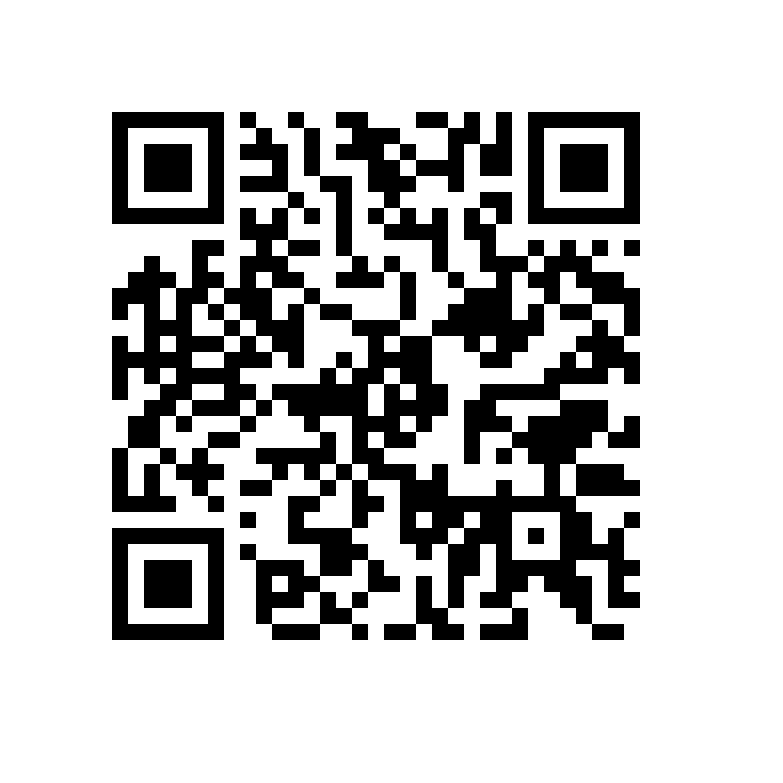

In [4]:
qrcode_gen = QrCodeGenerator()
qrcode_img = qrcode_gen.generator_qr_code('https://github.com/mf0212')

bg_qrcode = qrcode_gen.add_offset_background(qrcode_img)
bg_qrcode

QR CODE Conditioned Control Net for Stable Diffusion

In [5]:
# load ControlNet pre-train
from diffusers import ControlNetModel, StableDiffusionControlNetImg2ImgPipeline, DDIMScheduler
from diffusers.utils import load_image
from typing import Tuple
import torch

In [6]:
controlnet = ControlNetModel.from_pretrained("DionTimmer/controlnet_qrcode-control_v1p_sd15", torch_dtype = torch.float16)

In [7]:
cn_pipline = StableDiffusionControlNetImg2ImgPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    controlnet = controlnet
    , safety_checker = None
    , torch_dtype = torch.float16
)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet_img2img.StableDiffusionControlNetImg2ImgPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [8]:
cn_pipline.enable_xformers_memory_efficient_attention() #xformers memory efficient attention is only available for GPU
cn_pipline.scheduler = DDIMScheduler.from_config(cn_pipline.scheduler.config)
cn_pipline.enable_model_cpu_offload()

In [12]:
IMG_WIDTH = 768
IMG_HEIGHT = 768

def resize_for_input_image(input_image: Image, resolution: Tuple[int, int] = (IMG_WIDTH, IMG_HEIGHT)):
  input_image = input_image.convert("RGB")
  img = input_image.resize(resolution, resample = Image.LANCZOS)
  return img

# QR Code Image
condition_image = resize_for_input_image(bg_qrcode)
# Init Image: can be any thing
init_image = load_image("./seoul.jpeg")
init_image = resize_for_input_image(init_image)

In [13]:
generator = torch.Generator()

  0%|          | 0/27 [00:00<?, ?it/s]

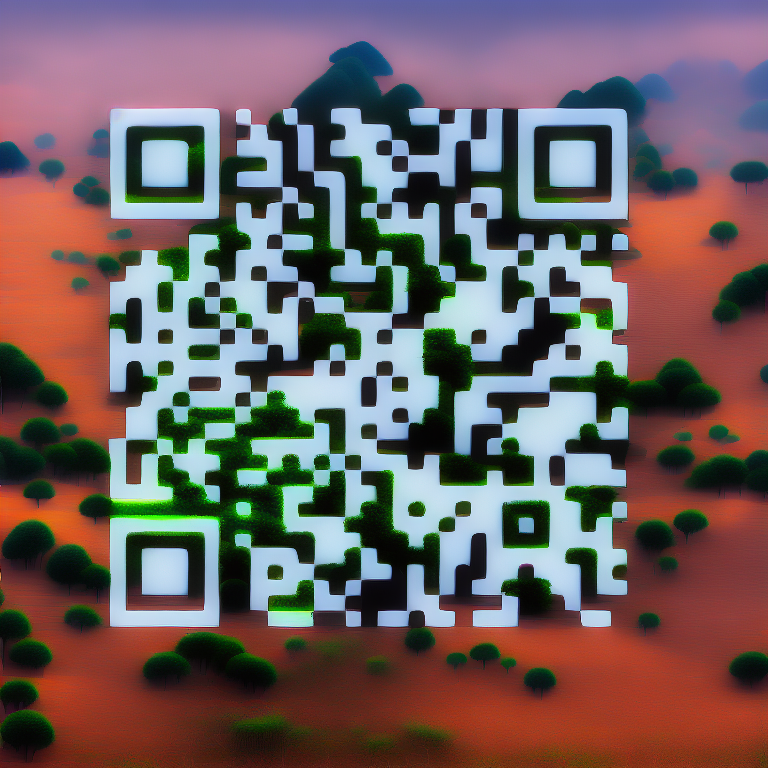

In [14]:
output = cn_pipline(
    prompt = "a peaceful countryside in VietName"
    , negative_prompt = "ugly, disfigured, low quality, blurry, nsfw"
    , image = init_image
    , control_image = condition_image
    , width = IMG_WIDTH
    , height = IMG_HEIGHT
    , guidance_scale = 7.5
    , controlnet_conditioning_scale = 2.9
    , strength = 0.9
    , num_inference_steps= 30
)
output.images[0]

In [ ]:
output.images[0].save("qr_code_github.jpeg")
